In [1]:
from folktables import ACSDataSource, ACSEmployment, ACSIncome
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.gaussian_process.kernels import RBF
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

from tqdm import tqdm
import scipy.stats

# local libraries
import sys

sys.path.append("..")
import metrics as mt

In [2]:
mt.hello()

you are doing great


In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
data_dict = {}

In [5]:
year = "2014"

for state in ["CA", "OH", "DE", "AK", "HI", "SD", "ND", "PA", "MI", "GA", "MS"]:
    data_dict[state] = {}
    data_source = ACSDataSource(survey_year=year, horizon="1-Year", survey="person")
    acs_data = data_source.get_data(states=[state], download=True)
    data_dict[state][year] = {}
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    data_dict[state][year]["x"] = features
    data_dict[state][year]["y"] = label
    data_dict[state][year]["g"] = group

In [6]:
state = "SD"
for year in ["2014", "2015", "2016", "2017", "2018"]:
    data_source = ACSDataSource(survey_year=year, horizon="1-Year", survey="person")
    acs_data = data_source.get_data(states=[state], download=True)
    data_dict[state][year] = {}
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    data_dict[state][year]["x"] = features
    data_dict[state][year]["y"] = label
    data_dict[state][year]["g"] = group

## Section 1: Distribution Shift Across Years

In [ ]:
# acoss years
state = "SD"
results = []
for clf in mt.clf_dict:
    for i in range(5):
        year = "2018"
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
            data_dict[state][year]["x"],
            data_dict[state][year]["y"],
            data_dict[state][year]["g"],
            test_size=0.2,
            random_state=i,
        )

        model = mt.model_choice(clf)

        model.fit(X_train, y_train)

        y_hat = model.predict(X_test)
        corr = y_hat == y_test
        g_acc_arr = mt.group_accuracy(corr, group_test)
        g_auc_arr = mt.group_auc(y_test, y_hat, group_test)

        results.append(
            {
                "year": year,
                "test_Accuracy": accuracy_score(y_hat, y_test),
                "disp_Accuracy": max(g_acc_arr) - min(g_acc_arr),
                "worst_g_Accuracy": min(g_acc_arr),
                "test_AUC": roc_auc_score(y_test, y_hat),
                "disp_AUC": max(g_auc_arr) - min(g_auc_arr),
                "worst_g_AUC": min(g_auc_arr),
                "size": len(y_train),
                "run": i,
                "clf": clf,
            }
        )
        for year in ["2018", "2017", "2016", "2015", "2014"]:
            (
                X_train,
                X_test,
                y_train,
                y_test,
                group_train,
                group_test,
            ) = train_test_split(
                data_dict[state][year]["x"],
                data_dict[state][year]["y"],
                data_dict[state][year]["g"],
                test_size=0.4,
                random_state=i,
            )
            y_hat = model.predict(X_test)
            corr = y_hat == y_test

            g_acc_arr = mt.group_accuracy(corr, group_test)
            g_auc_arr = mt.group_auc(y_test, y_hat, group_test)

            results.append(
                {
                    "year": year,
                    "test_Accuracy": accuracy_score(y_hat, y_test),
                    "disp_Accuracy": max(g_acc_arr) - min(g_acc_arr),
                    "worst_g_Accuracy": min(g_acc_arr),
                    "test_AUC": roc_auc_score(y_test, y_hat),
                    "disp_AUC": max(g_auc_arr) - min(g_auc_arr),
                    "worst_g_AUC": min(g_auc_arr),
                    "size": len(y_train),
                    "run": i,
                    "clf": clf,
                }
            )

In [ ]:
results_df = pd.DataFrame(results)
for metric in ["Accuracy", "AUC"]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.lineplot(data=results_df, x="year", y=f"test_{metric}", hue="clf", ax=axes[0])
    axes[0].set_title(metric)
    sns.lineplot(data=results_df, x="year", y=f"disp_{metric}", hue="clf", ax=axes[1])
    axes[1].set_title(f"{metric} disparity (Best group - worst group)")
    sns.lineplot(
        data=results_df, x="year", y=f"worst_g_{metric}", hue="clf", ax=axes[2]
    )
    axes[2].set_title(f"Worst group {metric}")
    plt.suptitle(f"{state} Model across different years trained on {year} ({metric})")
    plt.tight_layout()
    plt.savefig(f"../results/{state}_timeshift_{metric}.pdf")

## Section 2: Distribution Shift across states

In [9]:
# acoss states
results = []
year = "2014"
for clf in mt.clf_dict:
    print(clf)
    for i in range(1):
        ref_state = "CA"
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
            data_dict[ref_state][year]["x"],
            data_dict[ref_state][year]["y"],
            data_dict[ref_state][year]["g"],
            test_size=0.2,
            random_state=i,
        )

        model = mt.model_choice(clf, X_train, y_train)

        model.fit(X_train, y_train)

        y_hat = model.predict(X_test)
        corr = y_hat == y_test
        g_acc_arr = mt.group_accuracy(corr, group_test)
        g_auc_arr = mt.group_auc(y_test, y_hat, group_test)

        results.append(
            {
                "year": year,
                "test_Accuracy": accuracy_score(y_hat, y_test),
                "disp_Accuracy": max(g_acc_arr) - min(g_acc_arr),
                "worst_g_Accuracy": min(g_acc_arr),
                "test_AUC": roc_auc_score(y_test, y_hat),
                "disp_AUC": max(g_auc_arr) - min(g_auc_arr),
                "worst_g_AUC": min(g_auc_arr),
                "size": len(y_train),
                "run": i,
                "state": ref_state,
                "clf": clf,
            }
        )

        for state in ["SD", "ND", "PA", "MI", "GA", "MS"]:
            if state != ref_state:
                (
                    X_train,
                    X_test,
                    y_train,
                    y_test,
                    group_train,
                    group_test,
                ) = train_test_split(
                    data_dict[state][year]["x"],
                    data_dict[state][year]["y"],
                    data_dict[state][year]["g"],
                    test_size=0.4,
                    random_state=i,
                )
                y_hat = model.predict(X_test)
                corr = y_hat == y_test
                g_acc_arr = mt.group_accuracy(corr, group_test)
                g_auc_arr = mt.group_auc(y_test, y_hat, group_test)

                results.append(
                    {
                        "year": year,
                        "test_Accuracy": accuracy_score(y_hat, y_test),
                        "disp_Accuracy": max(g_acc_arr) - min(g_acc_arr),
                        "worst_g_Accuracy": min(g_acc_arr),
                        "test_AUC": roc_auc_score(y_test, y_hat),
                        "disp_AUC": max(g_auc_arr) - min(g_auc_arr),
                        "worst_g_AUC": min(g_auc_arr),
                        "size": len(y_train),
                        "run": i,
                        "state": state,
                        "clf": clf,
                    }
                )

LR
GB
XGB
SVM
NN
running model search


In [15]:
np.unique(y_test, return_counts=True)

(array([False,  True]), array([3965, 1119]))

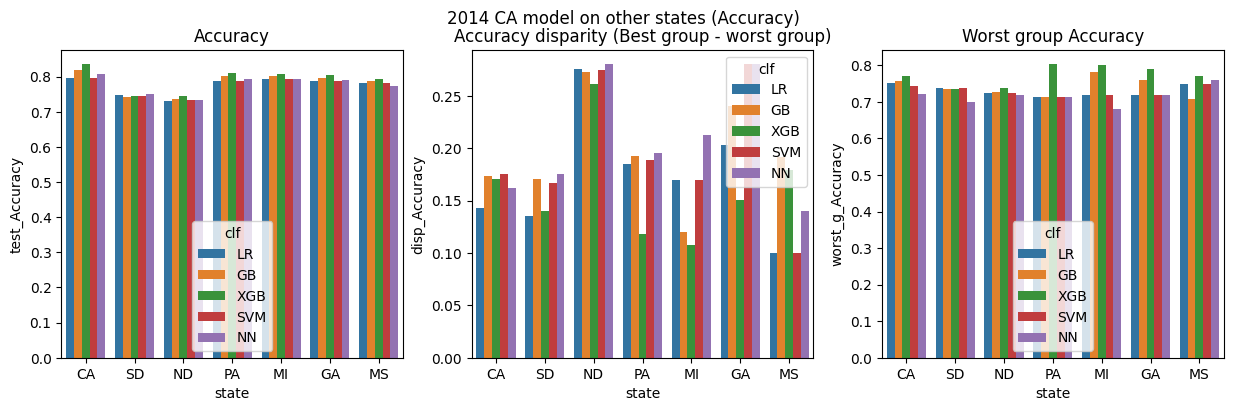

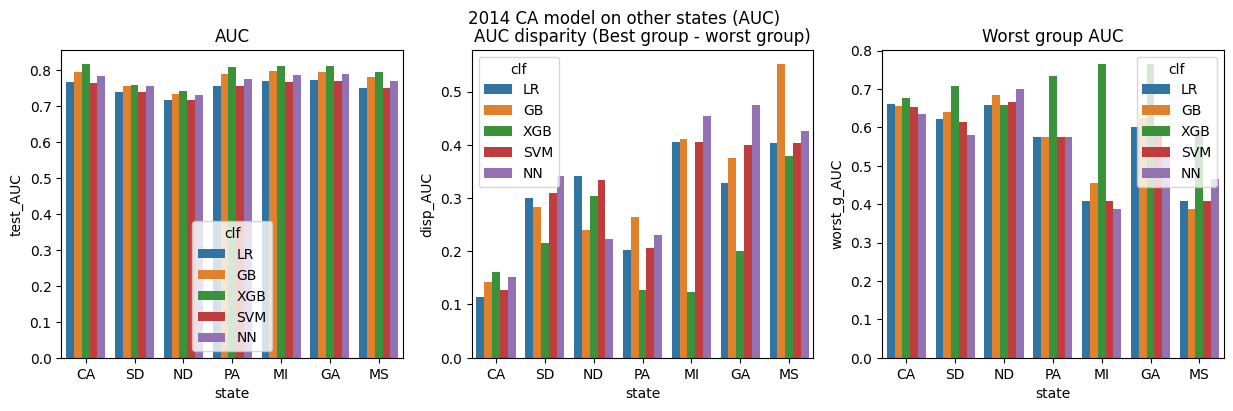

In [10]:
results_df = pd.DataFrame(results)
for metric in ["Accuracy", "AUC"]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.barplot(data=results_df, x="state", y=f"test_{metric}", hue="clf", ax=axes[0])
    axes[0].set_title(f"{metric}")
    sns.barplot(data=results_df, x="state", y=f"disp_{metric}", hue="clf", ax=axes[1])
    axes[1].set_title(f"{metric} disparity (Best group - worst group)")
    sns.barplot(
        data=results_df, x="state", y=f"worst_g_{metric}", hue="clf", ax=axes[2]
    )
    axes[2].set_title(f"Worst group {metric}")
    plt.suptitle(f"2014 {ref_state} model on other states ({metric})")

## Section 3: South Dakota case study

### Step 1: With in the SD dataset, more data is better

In [ ]:
results = []
state = "SD"
year = "2014"
size_arr = [100, 500, 1000, 2000]
for clf in mt.clf_dict.keys():
    for size in size_arr:
        print(size)
        for run in range(5):
            (
                X_train,
                X_test,
                y_train,
                y_test,
                group_train,
                group_test,
            ) = train_test_split(
                data_dict[state][year]["x"],
                data_dict[state][year]["y"],
                data_dict[state][year]["g"],
                test_size=0.2,
                random_state=0,
            )

            incl = np.asarray(random.sample(range(len(y_train)), size))

            X_train = X_train[incl]
            y_train = y_train[incl]
            model = mt.model_choice(clf)

            model.fit(X_train, y_train)

            y_hat = model.predict(X_test)
            corr = y_hat == y_test
            g_acc_arr = mt.group_accuracy(corr, group_test)
            g_auc_arr = mt.group_auc(y_test, y_hat, group_test)


            results.append(
                {
                    "year": year,
                    "test_Accuracy": accuracy_score(y_hat, y_test),
                    "disp_Accuracy": max(g_acc_arr) - min(g_acc_arr),
                    "worst_g_Accuracy": min(g_acc_arr),
                    "test_AUC": roc_auc_score(y_test, y_hat),
                    "disp_AUC": max(g_auc_arr) - min(g_auc_arr)
                    if len(g_auc_arr) > 0
                    else 0,
                    "worst_g_AUC": min(g_auc_arr) if len(g_auc_arr) > 0 else 0,
                    "size": len(y_train),
                    "run": i,
                    "clf": clf,
                }
            )

In [ ]:
results_df = pd.DataFrame(results)
for metric in ["Accuracy", "AUC"]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.lineplot(data=results_df, x="size", y=f"test_{metric}", hue="clf", ax=axes[0])
    axes[0].set_title("Accuracy")
    sns.lineplot(data=results_df, x="size", y=f"disp_{metric}", hue="clf", ax=axes[1])
    axes[1].set_title(f"{metric} disparity (Best group - worst group)")
    sns.lineplot(
        data=results_df, x="size", y=f"worst_g_{metric}", hue="clf", ax=axes[2]
    )
    axes[2].set_title(f"Worst group {metric}")
    plt.suptitle(f"{state} Model with increasing datasize ({metric})")

### Part 2: Example the effect of adding more data in the sequential and mixture setting

In [ ]:
len(data_dict["CA"]["2014"]["x"]), len(data_dict["SD"]["2014"]["x"])

In [28]:
results = []
state = "SD"
year = "2014"
mixture = False  # sequential if False, mixture if True
size_arr = [50, 100, 500, 1000, 2000, 4000, 8000, 12000, 14000, 16000]

for run in range(5):
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        data_dict[state][year]["x"],
        data_dict[state][year]["y"],
        data_dict[state][year]["g"],
        test_size=0.3,
        random_state=run,
    )

    X_joint = np.concatenate((X_train, data_dict["CA"][year]["x"]))
    y_joint = np.concatenate((y_train, data_dict["CA"][year]["y"]))
    g_joint = np.concatenate((group_train, data_dict["CA"][year]["g"]))
    if mixture:
        p = np.random.permutation(len(X_joint[: size_arr[-1]]))
        X_joint = X_joint[p]
        y_joint = y_joint[p]
        g_joint = g_joint[p]

    for clf in mt.clf_dict.keys():
        print(clf)
        for size in tqdm(size_arr):
            model = mt.model_choice(clf, X_joint[:size], y_joint[:size])

            model.fit(X_joint[:size], y_joint[:size])

            y_hat = model.predict(X_test)
            corr = y_hat == y_test
            g_acc_arr, acc_dict = mt.group_accuracy(corr, group_test)
            g_auc_arr, auc_dict = mt.group_auc(y_test, y_hat, group_test)
            g_f1_arr, f1_dict = mt.group_f1(y_test, y_hat, group_test)

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)

            # two groups only where we compare white and non-white
            # results.append(
            #     {
            #         "train_acc": train_acc,
            #         "test_Accuracy": accuracy_score(y_hat, y_test),
            #         "disp_Accuracy": acc_dict["white"] - acc_dict["non-white"],
            #         "worst_g_Accuracy": acc_dict["non-white"],
            #         "best_g_Accuracy": acc_dict["white"],
            #         "test_AUC": roc_auc_score(y_test, y_hat),
            #         "disp_AUC": auc_dict["white"] - auc_dict["non-white"],
            #         "worst_g_AUC": auc_dict["non-white"],
            #         "best_g_AUC": auc_dict["white"],
            #         "test_F1": f1_score(y_test, y_hat),
            #         "disp_F1": f1_dict["white"] - f1_dict["non-white"],
            #         "worst_g_F1": f1_dict["non-white"],
            #         "best_g_F1": f1_dict["white"],
            #         "size": size,
            #         "run": run,
            #         "clf": clf,
            #     }
            # )

            results.append(
                {
                    "train_acc": train_acc,
                    "test_Accuracy": accuracy_score(y_hat, y_test),
                    "disp_Accuracy": max(g_acc_arr) - min(g_acc_arr),
                    "worst_g_Accuracy": min(g_acc_arr),
                    "best_g_Accuracy": max(g_acc_arr),
                    "test_AUC": roc_auc_score(y_test, y_hat),
                    "disp_AUC": max(g_auc_arr) - min(g_auc_arr)
                    if len(g_auc_arr) > 0
                    else 0,
                    "worst_g_AUC": min(g_auc_arr) if len(g_auc_arr) > 0 else 0,
                    "best_g_AUC": max(g_auc_arr) if len(g_auc_arr) > 0 else 0,
                    "test_F1": f1_score(y_test, y_hat),
                    "disp_F1": max(g_f1_arr) - min(g_f1_arr),
                    "worst_g_F1": min(g_f1_arr),
                    "best_g_F1": max(g_f1_arr),
                    "size": size,
                    "run": run,
                    "clf": clf,
                }
            )

LR


100%|█████████████████████████████| 10/10 [00:00<00:00, 54.88it/s]


GB


100%|█████████████████████████████| 10/10 [00:04<00:00,  2.41it/s]


XGB


100%|█████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]


SVM


100%|█████████████████████████████| 10/10 [00:00<00:00, 19.20it/s]


LR


  0%|                                      | 0/10 [00:00<?, ?it/s]/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behav

GB


 20%|██████                        | 2/10 [00:00<00:00, 19.73it/s]/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 40%|████████████                  | 4/10 [00:00<00:00, 13.33it/s]/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor pred

XGB


 10%|███                           | 1/10 [00:00<00:01,  4.99it/s]/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 20%|██████                        | 2/10 [00:00<00:02,  3.98it/s]/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 50%|███████████████               | 5/10 [00:02<00:02,  2.06it/s]/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F

SVM


  0%|                                      | 0/10 [00:00<?, ?it/s]/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behav

LR


100%|█████████████████████████████| 10/10 [00:00<00:00, 59.11it/s]


GB


100%|█████████████████████████████| 10/10 [00:04<00:00,  2.42it/s]


XGB


100%|█████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


SVM


100%|█████████████████████████████| 10/10 [00:00<00:00, 19.03it/s]


LR


100%|█████████████████████████████| 10/10 [00:00<00:00, 55.08it/s]


GB


100%|█████████████████████████████| 10/10 [00:04<00:00,  2.43it/s]


XGB


100%|█████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]


SVM


100%|█████████████████████████████| 10/10 [00:00<00:00, 19.94it/s]


LR


100%|█████████████████████████████| 10/10 [00:00<00:00, 56.75it/s]


GB


100%|█████████████████████████████| 10/10 [00:04<00:00,  2.43it/s]


XGB


100%|█████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


SVM


100%|█████████████████████████████| 10/10 [00:00<00:00, 19.89it/s]


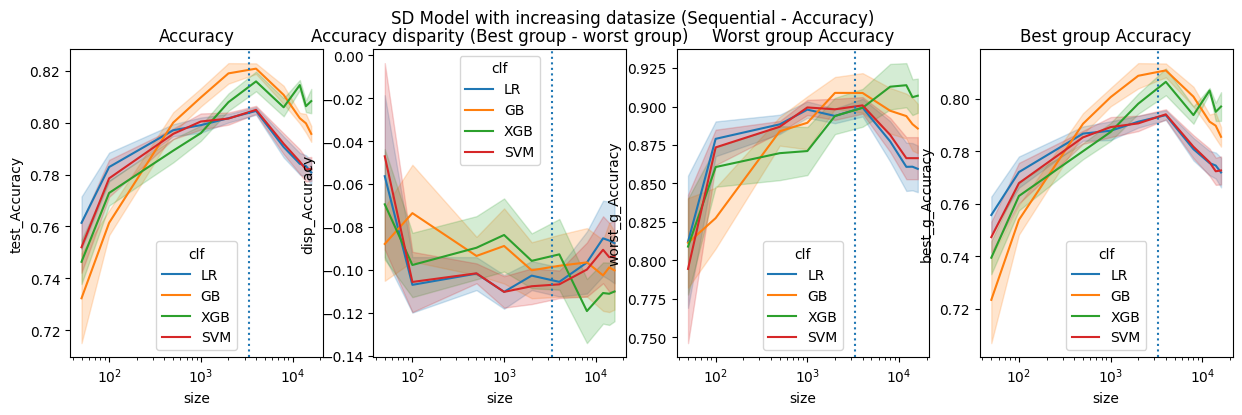

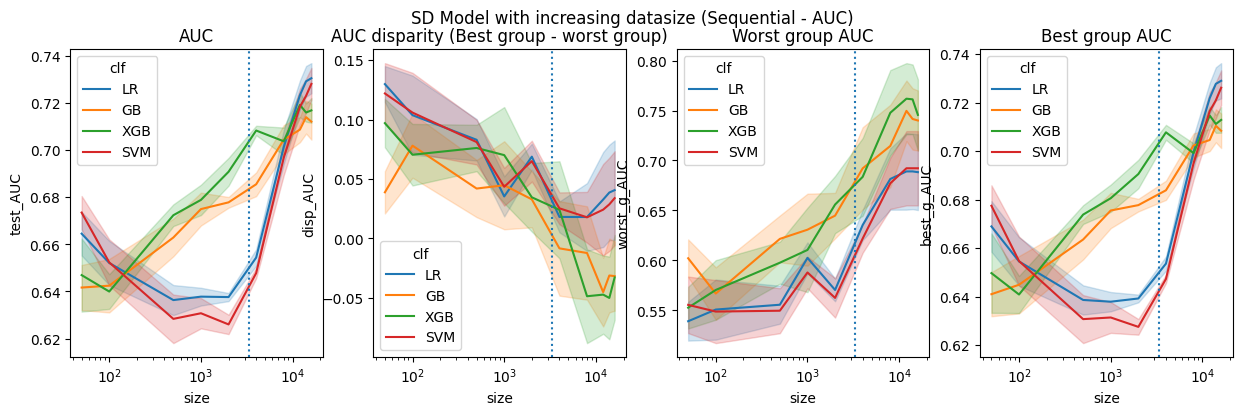

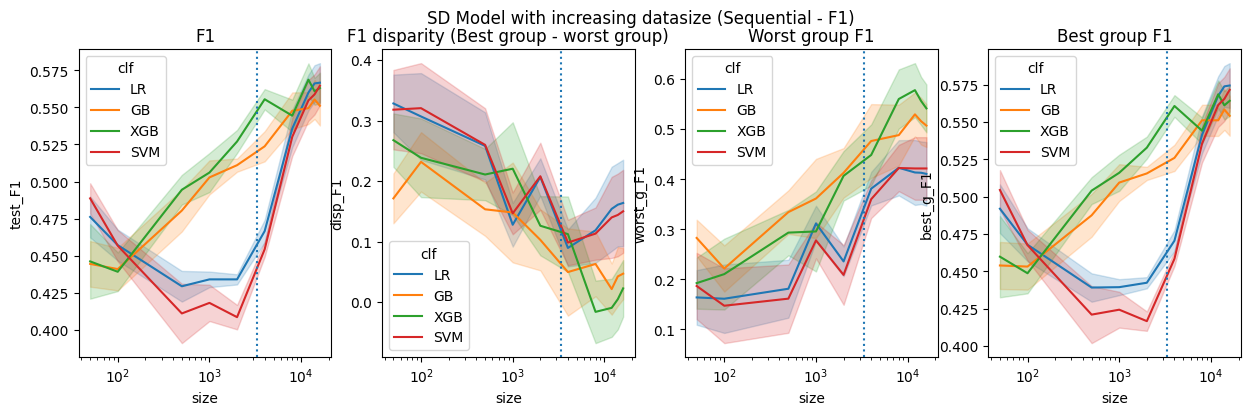

In [29]:
results_df = pd.DataFrame(results)


for metric in ["Accuracy", "AUC", "F1"]:
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    sns.lineplot(
        data=results_df,
        x="size",
        y=f"test_{metric}",
        hue="clf",
        errorbar="se",
        ax=axes[0],
    )
    axes[0].axvline(x=len(X_train), linestyle=":")
    axes[0].set_xscale("log")
    axes[0].set_title(f"{metric}")

    sns.lineplot(
        data=results_df,
        x="size",
        y=f"disp_{metric}",
        hue="clf",
        errorbar="se",
        ax=axes[1],
    )
    axes[1].set_title(f"{metric} disparity (Best group - worst group)")
    axes[1].axvline(x=len(X_train), linestyle=":")
    axes[1].set_xscale("log")

    sns.lineplot(
        data=results_df,
        x="size",
        y=f"worst_g_{metric}",
        hue="clf",
        errorbar="se",
        ax=axes[2],
    )
    axes[2].set_title(f"Worst group {metric}")
    axes[2].axvline(x=len(X_train), linestyle=":")
    axes[2].set_xscale("log")

    sns.lineplot(
        data=results_df,
        x="size",
        y=f"best_g_{metric}",
        hue="clf",
        errorbar="se",
        ax=axes[3],
    )
    axes[3].set_title(f"Best group {metric}")
    axes[3].axvline(x=len(X_train), linestyle=":")
    axes[3].set_xscale("log")
    if mixture:
        plt.suptitle(f"{state} Model with increasing datasize (Mixture - {metric}) ")
        results_df.to_csv(f"../results/{state}_mixture.csv")
    else:
        plt.suptitle(f"{state} Model with increasing datasize (Sequential - {metric})")
        results_df.to_csv(f"../results/{state}_sequential.csv")

In [ ]:
# stats tests

from scipy.stats import ttest_ind

df = pd.read_csv(f"../results/{state}_sequential.csv")
for metric in ["test_Accuracy", "worst_g_Accuracy"]:
    print(metric)
    for clf in mt.clf_dict.keys():
        print(clf)
        # Select the entries where "clf" == "LR" and "size" == 4000
        group_4 = df[(df["clf"] == clf) & (df["size"] == 4000)]["worst_g_Accuracy"]

        # Select the entries where "clf" == "LR" and "size" == 16000
        group_16 = df[(df["clf"] == clf) & (df["size"] == 16000)]["worst_g_Accuracy"]

        # Run a two-sample t-test
        t_stat, p_value = ttest_ind(group_4, group_16)
        print("Mean Difference:", group_4.mean() - group_16.mean())
        print("T-statistic:", t_stat)
        print("P-value:", p_value)

### Part 3: Check the effect of adding more data from SD in different years

In [ ]:
results = []
state = "SD"
year = "2018"
train_year = "2016"
size_arr = [50, 100, 500, 1000, 2000, 4000, 8000]
for run in range(5):
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        data_dict[state][year]["x"],
        data_dict[state][year]["y"],
        data_dict[state][year]["g"],
        test_size=0.2,
        random_state=run,
    )

    X_joint = np.concatenate((X_train, data_dict[state][train_year]["x"]))
    y_joint = np.concatenate((y_train, data_dict[state][train_year]["y"]))
    g_joint = np.concatenate((group_train, data_dict[state][train_year]["g"]))

    for clf in mt.clf_dict.keys():
        for size in size_arr:
            if clf == "XBG":
                model = make_pipeline(
                    StandardScaler(), clf_dict[clf](objective="binary:logistic")
                )
            else:
                model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_joint[:size], y_joint[:size])

            y_hat = model.predict(X_test)
            corr = y_hat == y_test
            g_acc_arr = mt.group_accuracy(corr, group_test)

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)

            results.append(
                {
                    "train_acc": train_acc,
                    "test_acc": test_acc,
                    "disp": max(g_acc_arr) - min(g_acc_arr),
                    "worst_g": min(g_acc_arr),
                    "size": size,
                    "run": run,
                    "clf": clf,
                }
            )

In [ ]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x="size", y="test_acc", hue="clf", ax=axes[0])
axes[0].axvline(x=len(X_train), linestyle=":")
axes[0].set_xscale("log")
axes[0].set_title("Accuracy")

sns.lineplot(data=results_df, x="size", y="disp", hue="clf", ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
axes[1].axvline(x=len(X_train), linestyle=":")
axes[1].set_xscale("log")

sns.lineplot(data=results_df, x="size", y="worst_g", hue="clf", ax=axes[2])
axes[2].set_title("Worst group accuracy")
axes[2].axvline(x=len(X_train), linestyle=":")
axes[2].set_xscale("log")
plt.suptitle(f"{state} Model with data from prev years")
plt.savefig(f"../results/temporal_sequential_{state}.pdf")

## Section 3: Empirical KL

### Part 1: Evaluate KL via empirical kernel density estimation between source and target distributiosn (States)

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import scipy.special as sp
from sklearn.model_selection import GridSearchCV

In [ ]:
# run state classifier in above
state_results = results_df
states_mean = state_results.groupby(['state', 'clf']).mean()

In [ ]:
ref_state = "CA"
samples = 3000
joint_xy_ref = np.concatenate(
    (data_dict[ref_state][year]["x"], data_dict[ref_state][year]["y"].reshape(-1, 1)),
    axis=1,
)

incl = np.asarray(random.sample(range(len(joint_xy_ref)), samples))

cx, pkdex = mt.init_density_scale(data_dict[ref_state][year]["x"][incl])

cxy, pkdexy = mt.init_density_scale(joint_xy_ref[incl])

num_iter = 1
for i in range(num_iter):
    kl_df = pd.DataFrame()
    for state in data_dict.keys():
        print(state)
        if state != ref_state:
            joint_xy = np.concatenate(
                (
                    data_dict[state][year]["x"],
                    data_dict[state][year]["y"].reshape(-1, 1),
                ),
                axis=1,
            )

            diff_df = states_mean.loc[ref_state] - states_mean.loc[state]

            # sample
            incl = np.asarray(random.sample(range(len(joint_xy)), samples))
            qkdexy = mt.init_density(joint_xy[incl], cxy)
            qkdex = mt.init_density(data_dict[state][year]["x"][incl], cx)

            diff_df["KL_x"] = mt.entropy_input(
                data_dict[ref_state][year]["x"][incl], pkdex, qkdex, cx
            )
            diff_df["KL_xy"] = mt.entropy_input(joint_xy_ref[incl], pkdexy, qkdexy, cxy)
            diff_df["state"] = state
            diff_df["iter"] = i
            kl_df = pd.concat((kl_df, diff_df))
kl_df.to_csv("results/kl_shift.csv")

In [ ]:
kl_df.shape

In [ ]:
kl_df = pd.read_csv("results/kl_shift.csv")
kl_df = kl_df.reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(
    data=kl_df,
    x="KL_x",
    y="test_acc",
    hue="state",
    style="clf",
    ax=axes[0],
    legend=False,
)
axes[0].set_ylabel("Accuracy Drop")
coeff, p = scipy.stats.pearsonr(kl_df["test_acc"], kl_df["KL_xy"])
print(coeff, p)
sns.scatterplot(
    data=kl_df,
    x="KL_xy",
    y="test_acc",
    style="clf",
    hue="state",
    ax=axes[1],
)
axes[1].set_ylabel("Accuracy Drop")
axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.suptitle(
    "KL divergence between KL(p(CA train) || p(State_test)) with respect to accuracy drop"
)

### Part 2: Evaluate Excess KL across states

In [ ]:
# calculate KL to current data vs kl to new dataset
# scatter plot x=excess kl y = accuracy improvement, these points should come from many states:

# sequential
results = []
state = "SD"
year = "2014"

# init kde and transform with SD data
joint_xy_ref = np.concatenate(
    (data_dict[ref_state][year]["x"], data_dict[ref_state][year]["y"].reshape(-1, 1)),
    axis=1,
)
incl = np.asarray(random.sample(range(len(joint_xy_ref)), samples * 2))

cx, qkdex = mt.init_density_scale(data_dict[ref_state][year]["x"][incl])
cxy, qkdexy = mt.init_density_scale(joint_xy_ref[incl])

mixture = False
size_arr = [3500, 7500]
for extra_state in tqdm(data_dict.keys()):
    if extra_state != state:
        for run in range(1):
            (
                X_train,
                X_test,
                y_train,
                y_test,
                group_train,
                group_test,
            ) = train_test_split(
                data_dict[state][year]["x"],
                data_dict[state][year]["y"],
                data_dict[state][year]["g"],
                test_size=0.25,
                random_state=run,
            )

            X_joint = np.concatenate((X_train, data_dict[extra_state][year]["x"]))
            y_joint = np.concatenate((y_train, data_dict[extra_state][year]["y"]))
            g_joint = np.concatenate((group_train, data_dict[extra_state][year]["g"]))

            Xy_joint = np.concatenate((X_joint, y_joint.reshape(-1, 1)), axis=1)

            for size in size_arr:
                # sample
                pkdex = mt.init_density(X_joint[:size], cx)
                pkdexy = mt.init_density(Xy_joint[:size], cxy)
                kl_x = mt.entropy_input(X_joint[:size], pkdex, qkdex, cx)
                kl_xy = mt.entropy_input(Xy_joint[:size], pkdexy, qkdexy, cxy)

                for clf in clf_dict.keys():
                    if clf == "XBG":
                        model = make_pipeline(
                            StandardScaler(), clf_dict[clf](objective="binary:logistic")
                        )
                    else:
                        model = make_pipeline(StandardScaler(), clf_dict[clf]())

                        model.fit(X_joint[:size], y_joint[:size])

                        y_hat = model.predict(X_test)
                        corr = y_hat == y_test
                        g_acc_arr = mt.group_accuracy(corr, group_test)

                        train_acc = model.score(X_train, y_train)

                        test_acc = model.score(X_test, y_test)

                        results.append(
                            {
                                "train_acc": train_acc,
                                "test_acc": test_acc,
                                "disp": max(g_acc_arr) - min(g_acc_arr),
                                "worst_g": min(g_acc_arr),
                                "kl_testx": kl_x,
                                "kl_testxy": kl_xy,
                                "size": size,
                                "run": run,
                                "clf": clf,
                                "extra_state": extra_state,
                            }
                        )

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
q1_results = results_df[results_df["size"] == 3500].reset_index()[
    ["test_acc", "clf", "extra_state", "kl_testx", "kl_testxy"]
]

In [ ]:
q2_results = results_df[results_df["size"] == 7500].reset_index()[
    ["test_acc", "clf", "extra_state", "kl_testx", "kl_testxy"]
]

In [ ]:
diff_results = pd.DataFrame()
diff_results["acc_diff"] = q1_results["test_acc"] - q2_results["test_acc"]
diff_results["klx_diff"] = q1_results["kl_testx"] - q2_results["kl_testx"]
diff_results["klxy_diff"] = q1_results["kl_testxy"] - q2_results["kl_testxy"]
diff_results["clf"] = q1_results["clf"]
diff_results["extra_state"] = q1_results["extra_state"]

In [ ]:
diff_results.to_csv("results/excess_kl.csv")

In [ ]:
len(clf_df["acc_diff"])

In [ ]:
for clf in clf_dict.keys():
    clf_df = diff_results[diff_results["clf"] == clf]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.scatterplot(
        data=clf_df,
        x="klx_diff",
        y="acc_diff",
        hue="extra_state",
        # style="clf",
        ax=axes[0],
        legend=False,
    )
    axes[0].set_xlabel("Excess KL")
    axes[0].set_ylabel("Accuracy Drop")
    sns.scatterplot(
        data=clf_df,
        x="klxy_diff",
        y="acc_diff",
        hue="extra_state",
        # style="clf",
        ax=axes[1],
    )
    axes[1].set_xlabel("Excess KL")
    axes[1].set_ylabel("Accuracy Drop")
    axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    coeff, p = scipy.stats.pearsonr(clf_df["acc_diff"], clf_df["klxy_diff"])
    print(coeff, p)
    plt.suptitle("Excess KL divergence vs accuracy drop")
    plt.show()

In [ ]:
kl_df = pd.read_csv("results/kl_shift.csv")
diff_results = pd.read_csv("results/excess_kl.csv")

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
sns.scatterplot(
    data=kl_df,
    x="KL_xy",
    y="test_acc",
    style="clf",
    hue="state",
    ax=axes[0],
)
axes[0].set_ylabel("Accuracy Drop")
axes[0].set_xlabel("KL(p(CA) || p(State))")
axes[0].legend(loc="center left", bbox_to_anchor=(-0.5, 0.5))
axes[0].set_title("KL(p(CA train) || p(State test)) \n wrt to Accuracy Drop")

sns.scatterplot(
    data=diff_results[diff_results["clf"] == "LR"],
    x="klx_diff",
    y="acc_diff",
    hue="extra_state",
    # style="clf",
    ax=axes[1],
    legend=False,
)
axes[1].set_xlabel("Excess KL")
axes[1].set_ylabel("Accuracy Drop")
axes[1].set_title("Excess KL divergence vs \n Accuracy Drop for LR")

sns.scatterplot(
    data=diff_results[diff_results["clf"] == "GB"],
    x="klxy_diff",
    y="acc_diff",
    hue="extra_state",
    legend=False,
    # style="clf",
    ax=axes[2],
)
axes[2].set_xlabel("Excess KL")
axes[2].set_ylabel("Accuracy Drop")
# axes[2].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes[2].set_title("Excess KL divergence vs \n Accuracy Drop for GB")


sns.scatterplot(
    data=diff_results[diff_results["clf"] == "XGB"],
    x="klxy_diff",
    y="acc_diff",
    hue="extra_state",
    legend=True,
    # style="clf",
    ax=axes[3],
)
axes[3].set_xlabel("Excess KL")
axes[3].set_ylabel("Accuracy Drop")
axes[3].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes[3].set_title("Excess KL divergence vs \n Accuracy Drop for XGB")
fig.tight_layout()
plt.savefig("KL.pdf")
plt.show()